# 2) Analyze source collection and target file

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in our audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Pythonn bindings of the Essentia library which was introduced in the first session of AMPLAB. Please make sure you checked the [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html) to get familiarized with using Essentia in Python. Also useful is to always have a browser tab opened with Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

## 2.1 Split the audio first using Onset detection function
> An initial idea was to compute the beats and use these for segmentation. However after some experimentation, I decided to use onset detection instead for segmentation due to the amount of audio events occuring inbetween beats which would otherwise potentially be lost using just a beat segmentation when the audio was reconstructed.

In [372]:
import pandas as pd
import essentia
import essentia.standard as estd
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import numpy as np
from essentia.standard import *
from pylab import plot, show, figure, imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [373]:
TARGET_SOUND_PATH_BREAK = '194817__csum__amen-break-mashed-164bpm.wav'  # Filename of the target audio we'll reconstruct
TARGET_SOUND_PATH_PIANO = '486472__tkky__piano-chopped-edited.wav'      # Filename of the target audio we'll reconstruct

DATAFRAME_FILENAME_BREAK = 'dataframe-break.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME_BREAK = 'dataframe_source-break.csv'  # DataFrame file where to store the results of our analysis
DATAFRAME_TARGET_FILE_FILENAME_BREAK = 'dataframe_target-break.csv'  # DataFrame file where to store the analysis results of the target audio

DATAFRAME_FILENAME_PIANO = 'dataframe-piano.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME_PIANO = 'dataframe_source-piano.csv'  # DataFrame file where to store the results of our analysis
DATAFRAME_TARGET_FILE_FILENAME_PIANO = 'dataframe_target-piano.csv'  # DataFrame file where to store the analysis results of the target audio

In [374]:
def compute_beats(audio_path):
    upper_b = 44100 * 3
    # load audio
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()
    audio = audio[:upper_b]
    # extract beats
    beat_tracker_algo = estd.BeatTrackerDegara()
    beat_positions = beat_tracker_algo(audio)
    beat_positions = [int(round(position * 44100)) for position in beat_positions]
    
    # plot beat locations for first 3 secs
    plt.rcParams['figure.figsize'] = (15, 6) # set plot sizes to something larger than default

    plot(audio[:upper_b])
    for beat_pos in beat_positions:
        plt.axvline(x=beat_pos, color='red')

    plt.title("Audio waveform and the estimated beat positions")   

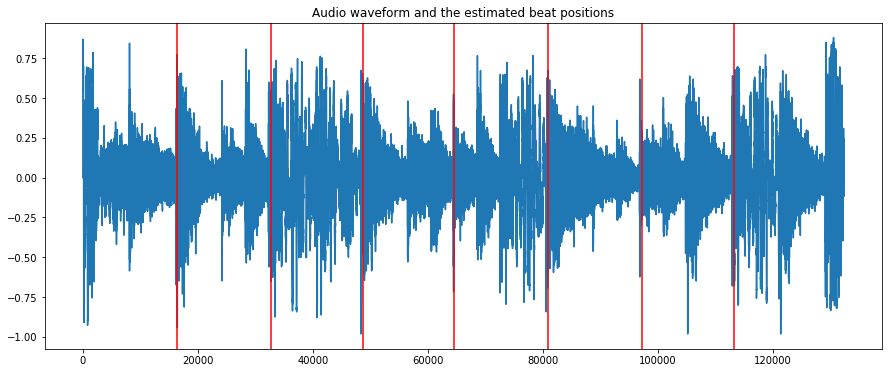

In [375]:
# demo of beat detection function - not used
compute_beats(TARGET_SOUND_PATH_BREAK)

## 2.2 Comparing Onset Detection Functions

> We now compare 3 onset detction functions from the Essentia library to see which gives the best performance with our amen break-beat and also for the piano sample.  

In [376]:
def plot_audio_onsets(audio_path, onsets, title):
    upper_b = 44100 * 3 #bound to 3secs
    target_audio = estd.MonoLoader(filename=audio_path)()
    audio = target_audio[:upper_b]
    
    plt.rcParams['figure.figsize'] = (15, 6) # set plot sizes to something larger than default
    plot(audio[:upper_b]) #plot first 3secs of audio
              
    # plotting first 3 seconds
    onsets_filter =[i for i in onsets if i <= upper_b]
    for onset in onsets_filter:
        plt.axvline(x=onset, color='red')

    plt.title("Audio waveform and the estimated {} onset positions".format(title)) 
    plt.show()

In [377]:
from essentia.standard import *

def compute_onsets_hfc_complex(audio_path):
    target_audio = estd.MonoLoader(filename=audio_path)()
    audio = target_audio
    # Phase 1: compute the onset detection function
    # The OnsetDetection algorithm provides various onset detection functions. Let’s use two of them.
    od1 = OnsetDetection(method='hfc')
    od2 = OnsetDetection(method='complex')
    # Let’s also get the other algorithms we will need, and a pool to store the results
    w = Windowing(type = 'hann')
    fft = FFT() # this gives us a complex FFT
    c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
    pool = essentia.Pool()
    # Computing onset detection functions.
    for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features.hfc', od1(mag, phase))
        pool.add('features.complex', od2(mag, phase))
    # Phase 2: compute the actual onsets locations
    onsets = Onsets()
    onsets_hfc = onsets(# this algo expects a matrix, not a vector
                        essentia.array([ pool['features.hfc'] ]),
                        # you need to specify weights, but as there is only a single
                        # function, it doesn’t actually matter which weight you give it
                        [ 1 ])
    onsets_complex = onsets(essentia.array([ pool['features.complex'] ]), [ 1 ])
    return onsets_hfc*44100, onsets_complex*44100

In [378]:
def compute_onsets_specflux(audio_path):
    # Load audio file
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()
    superflux_extractor = SuperFluxExtractor(threshold=0.04)
    onsets = superflux_extractor(audio)
    onsets = onsets*44100
    onsets = list(map(int, onsets))
    return onsets

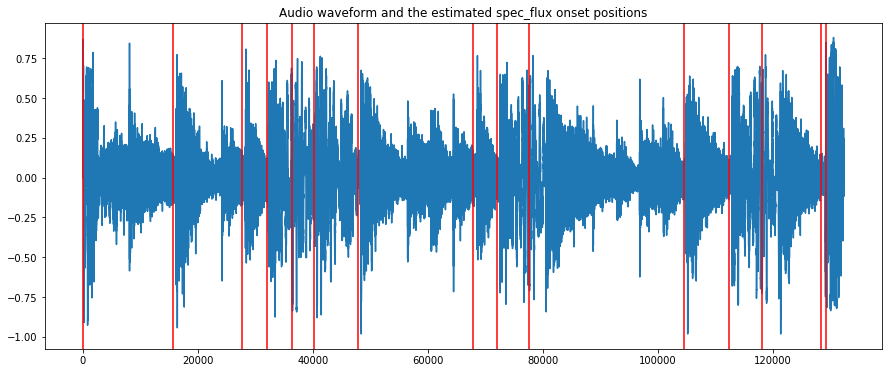

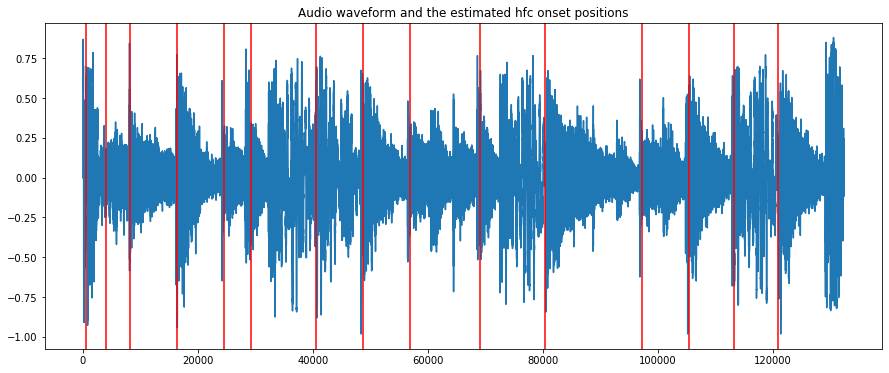

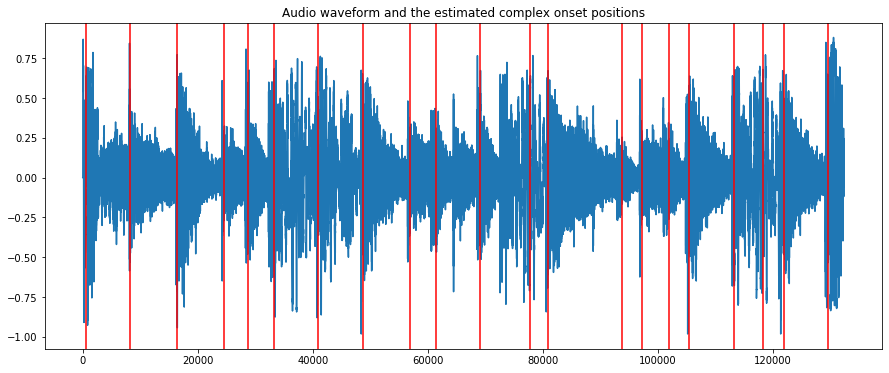

In [379]:
# (1) Break-beat: comparison of onset detction functions 
onsets_specflux = compute_onsets_specflux(TARGET_SOUND_PATH_BREAK)
onsets_hfc, onsets_complex = compute_onsets_hfc_complex(TARGET_SOUND_PATH_BREAK)

plot_audio_onsets(TARGET_SOUND_PATH_BREAK, onsets_specflux, 'spec_flux')
plot_audio_onsets(TARGET_SOUND_PATH_BREAK, onsets_hfc, 'hfc')
plot_audio_onsets(TARGET_SOUND_PATH_BREAK, onsets_complex, 'complex')

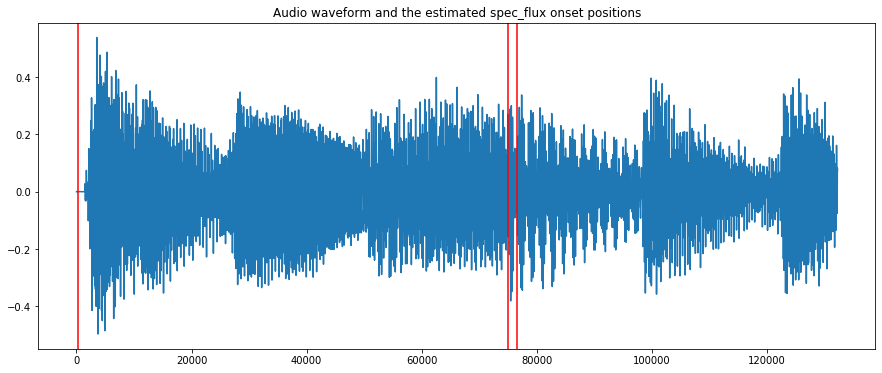

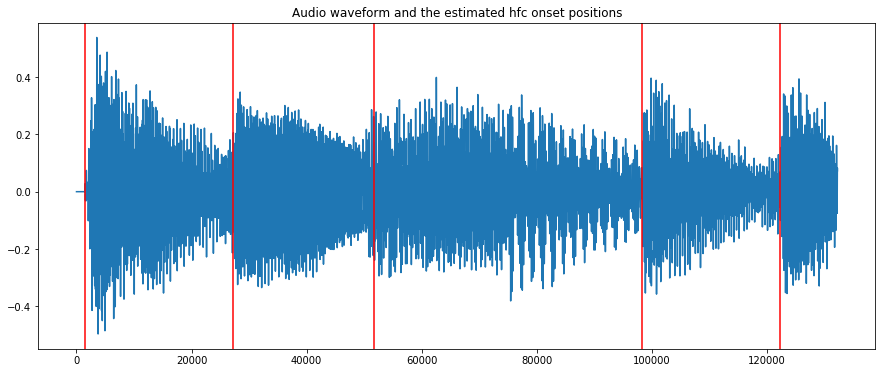

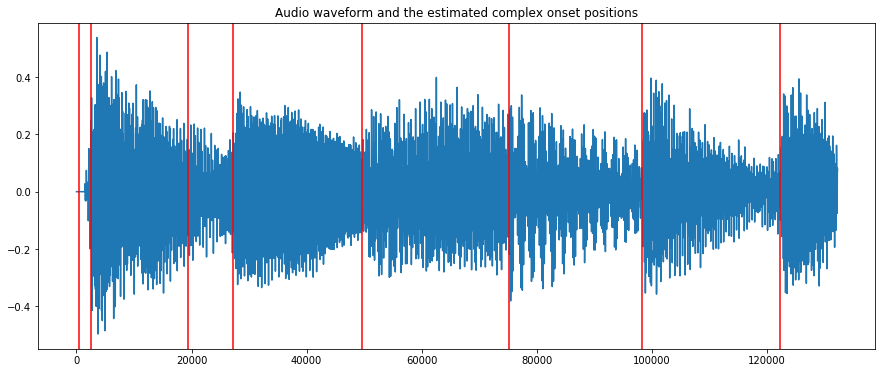

In [380]:
# (2) Piano: comparison of onset detction functions 
onsets_specflux = compute_onsets_specflux(TARGET_SOUND_PATH_PIANO)
onsets_hfc, onsets_complex = compute_onsets_hfc_complex(TARGET_SOUND_PATH_PIANO)

plot_audio_onsets(TARGET_SOUND_PATH_PIANO, onsets_specflux, 'spec_flux')
plot_audio_onsets(TARGET_SOUND_PATH_PIANO, onsets_hfc, 'hfc')
plot_audio_onsets(TARGET_SOUND_PATH_PIANO, onsets_complex, 'complex')

**Observations:**
> From this analysis, we observe that the complex onset function provides the best results for the amen break. Hence, we use this function for our final segmentations made before analysis. In comparison, we also observe that the hfc onset detection works better for the piano and hence, we apply this algorithm in this context.

Okay that looks abit better than our previous random splitting, lets analyse the sound by each inter onset now!

## 2.3 Target Sound Analysis 

In [381]:
def analyze_sound_per_onset(audio_path, onsets=None, audio_id=None, melodic=False):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will 
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as 
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be 
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file
    
    # Load audio file
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()
    
    onset_i = np.arange(0, len(onsets)-1)
    for i in onset_i:
        fstart = int(onsets[i])
        fend = int(onsets[i+1]) 
        
        if (fend-fstart) % 2 != 0: frame = audio[fstart:fend+1]
        else: frame = audio[fstart:fend]
     
        frame_output = {
            'freesound_id': audio_id,
            'id': '{0}_f{1}'.format(audio_id, i),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }
        
        # Extract loudness
        loudness_algo = estd.Loudness()
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

        # Extract MFCC coefficients
        w_algo = estd.Windowing(type = 'hann')
        spectrum_algo = estd.Spectrum()
        mfcc_algo = estd.MFCC()
        spec = spectrum_algo(w_algo(frame))
        _, mfcc_coeffs = mfcc_algo(spec)
        frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})
        
        # Extract other features here and add to 'frame_output' dictionary

        # (1) compute temperal aspects, the atack
        a_algo = estd.LogAttackTime()
        attack = a_algo(frame)
        a_time = attack[0]
        a_start = attack[1]
        a_stop = attack[2]
        frame_output.update({'attack_time' : a_time})
        frame_output.update({'attack_start' : a_start})
        frame_output.update({'attack_stop' : a_stop})
        
        # Add frame analysis results to output
        analysis_output.append(frame_output)
        
        # Add frame analysis results to output
        analysis_output.append(frame_output)
        
        # (2) Compute zero crossing rate to detect changes in nosiy-ness in the signal
        z_algo = ZeroCrossingRate()
        zc_rate = z_algo(frame)
        frame_output.update({'zero_crossing' : zc_rate})
        
        # (3) Compute Spectral centroid in time domain
        sct_algo = SpectralCentroidTime()
        spec_cent = sct_algo(frame)
        frame_output.update({'spec_centroid': spec_cent})
        
        # (4) if we are considering a melodic, piece, also compute pitch
        if melodic:
            #print('melodic true')
            pitch_algo = PitchMelodia()
            pitchcontorsep_algo = PitchContourSegmentation()
            pitch_contor, pitch_confidence = pitch_algo(frame)
            onset, duration, pitch = pitchcontorsep_algo(pitch_contor, frame)
            if len(pitch) >= 1: pitch = pitch[0]
            else: pitch = 0 # todo: questionable to set this to 0 as a midi note...
            frame_output.update({'pitch': pitch})
        
    return analysis_output

### 2.3.1 Amen Break

Analyzing target sound 194817__csum__amen-break-mashed-164bpm.wav


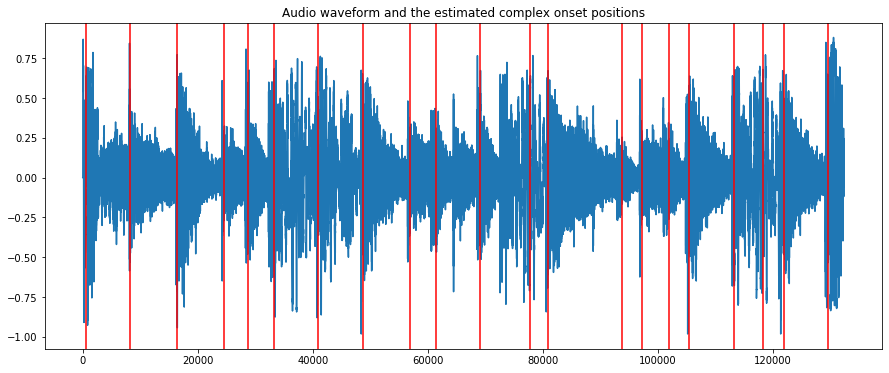

Saved target dataframe with 306 entries! dataframe_target-break.csv


,attack_start,attack_stop,attack_time,end_sample,freesound_id,id,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,spec_centroid,start_sample,zero_crossing
0,0.000045,0.027959,-1.554181,8192,None,None_f0,0.008306,-669.507568,85.321991,-8.762383,...,4.044270,31.914343,4.742237,17.500086,-0.328320,4.612965,194817__csum__amen-break-mashed-164bpm.wav,950.996216,512,0.056250
1,0.000045,0.027959,-1.554181,8192,None,None_f0,0.008306,-669.507568,85.321991,-8.762383,...,4.044270,31.914343,4.742237,17.500086,-0.328320,4.612965,194817__csum__amen-break-mashed-164bpm.wav,950.996216,512,0.056250
2,0.000249,0.185714,-0.731738,16384,None,None_f1,0.002464,-682.917847,20.525978,-11.040756,...,-2.999397,12.699234,-23.492647,17.184380,-4.272991,-2.984688,194817__csum__amen-break-mashed-164bpm.wav,3583.469482,8192,0.161499
3,0.000249,0.185714,-0.731738,16384,None,None_f1,0.002464,-682.917847,20.525978,-11.040756,...,-2.999397,12.699234,-23.492647,17.184380,-4.272991,-2.984688,194817__csum__amen-break-mashed-164bpm.wav,3583.469482,8192,0.161499
4,0.000000,0.000000,-5.000000,24576,None,None_f2,0.004289,-619.264709,80.228195,4.594421,...,-10.736647,19.028648,-14.272860,6.943010,-9.194096,9.052673,194817__csum__amen-break-mashed-164bpm.wav,2609.977783,16384,0.131226
5,0.000000,0.000000,-5.000000,24576,None,None_f2,0.004289,-619.264709,80.228195,4.594421,...,-10.736647,19.028648,-14.272860,6.943010,-9.194096,9.052673,194817__csum__amen-break-mashed-164bpm.wav,2609.977783,16384,0.131226
6,0.000136,0.085964,-1.066373,28671,None,None_f3,0.003807,-637.242554,32.946201,-17.391975,...,-3.330786,-8.191971,-26.165211,13.253983,-8.355799,-5.828327,194817__csum__amen-break-mashed-164bpm.wav,2322.358643,24576,0.134521
7,0.000136,0.085964,-1.066373,28671,None,None_f3,0.003807,-637.242554,32.946201,-17.391975,...,-3.330786,-8.191971,-26.165211,13.253983,-8.355799,-5.828327,194817__csum__amen-break-mashed-164bpm.wav,2322.358643,24576,0.134521
8,0.000000,0.005215,-2.282711,33280,None,None_f4,0.006401,-605.759583,50.537590,-5.448513,...,-13.425003,8.654547,-25.821342,10.491755,-4.209463,8.570589,194817__csum__amen-break-mashed-164bpm.wav,2057.865479,28671,0.128850
9,0.000000,0.005215,-2.282711,33280,None,None_f4,0.006401,-605.759583,50.537590,-5.448513,...,-13.425003,8.654547,-25.821342,10.491755,-4.209463,8.570589,194817__csum__amen-break-mashed-164bpm.wav,2057.865479,28671,0.128850


,attack_start,attack_stop,attack_time,end_sample,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,...,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,spec_centroid,start_sample,zero_crossing
count,306.000000,306.000000,306.000000,3.060000e+02,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,...,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,3.060000e+02,306.000000
mean,0.000627,0.055655,-1.863906,5.170731e+05,0.007133,-640.396457,71.167742,-6.345956,0.319511,-11.856566,...,79.661752,-2.327812,16.895180,-13.335831,15.417077,-3.985479,1.267944,1983.064875,5.103468e+05,0.104366
std,0.001151,0.058899,1.057802,3.012767e+05,0.004103,31.609278,32.117319,6.307871,5.426250,5.080381,...,20.734728,15.661270,13.459996,12.191455,10.075723,8.875792,5.988887,997.964816,3.012462e+05,0.052014
min,0.000000,0.000000,-5.000000,8.192000e+03,0.002079,-707.128052,6.990948,-19.705214,-14.685184,-25.519873,...,45.850582,-25.480637,-8.881535,-42.279804,-5.547068,-20.675312,-17.433060,376.765442,5.120000e+02,0.011502
25%,0.000000,0.004580,-2.527167,2.503680e+05,0.003918,-663.510071,46.955475,-11.570042,-2.994102,-14.768387,...,62.299145,-16.259911,5.893702,-22.335896,7.410322,-10.582146,-3.168842,968.964783,2.426880e+05,0.053850
50%,0.000113,0.055669,-1.259727,5.084160e+05,0.005434,-637.743042,70.661041,-5.557501,0.224087,-11.660793,...,69.231247,-5.628424,17.839930,-14.358400,16.412006,-4.272991,0.753460,2234.259033,5.007360e+05,0.129427
75%,0.000612,0.080839,-1.092745,7.751680e+05,0.009823,-622.290344,86.805038,-2.319801,4.613312,-9.547657,...,100.856277,12.692207,28.681944,-2.757103,23.299154,1.921200,6.040125,2738.137695,7.680000e+05,0.143066
max,0.005533,0.260907,-0.583514,1.029632e+06,0.018181,-527.583191,142.545837,10.765614,12.162491,3.089573,...,122.783813,30.553669,41.634590,7.752949,35.286453,18.022575,17.427650,3844.546631,1.025535e+06,0.184326


In [382]:
# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH_BREAK))

# compute onsets first
onsets_hfc, onsets_complex = compute_onsets_hfc_complex(TARGET_SOUND_PATH_BREAK)
plot_audio_onsets(TARGET_SOUND_PATH_BREAK, onsets_complex, 'complex')
# split and analyse sounds
target_analysis = analyze_sound_per_onset(TARGET_SOUND_PATH_BREAK, onsets_complex)

df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME_BREAK)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME_BREAK))

display(df_target)    # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame

### 2.3.2 Piano

Analyzing target sound 486472__tkky__piano-chopped-edited.wav


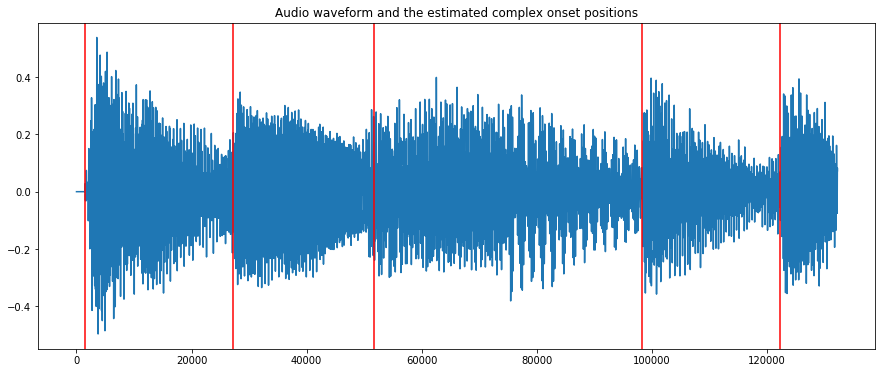

Saved target dataframe with 78 entries! dataframe_target-piano.csv


,attack_start,attack_stop,attack_time,end_sample,freesound_id,id,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,pitch,spec_centroid,start_sample,zero_crossing
0,0.013537,0.045011,-1.502049,27136,None,None_f0,0.002359,-949.306702,221.774445,10.786976,...,-38.975765,-18.923683,-4.486160,0.951736,5.439293,486472__tkky__piano-chopped-edited.wav,50.0,501.718292,1536,0.022578
1,0.013537,0.045011,-1.502049,27136,None,None_f0,0.002359,-949.306702,221.774445,10.786976,...,-38.975765,-18.923683,-4.486160,0.951736,5.439293,486472__tkky__piano-chopped-edited.wav,50.0,501.718292,1536,0.022578
2,0.002562,0.021020,-1.733814,51711,None,None_f1,0.002540,-977.275391,194.685028,12.268459,...,-38.965069,-31.144066,-17.219925,-4.878357,5.272659,486472__tkky__piano-chopped-edited.wav,69.0,430.456329,27136,0.019328
3,0.002562,0.021020,-1.733814,51711,None,None_f1,0.002540,-977.275391,194.685028,12.268459,...,-38.965069,-31.144066,-17.219925,-4.878357,5.272659,486472__tkky__piano-chopped-edited.wav,69.0,430.456329,27136,0.019328
4,0.000476,0.245964,-0.609971,98304,None,None_f2,0.001944,-996.813965,174.761230,-9.862410,...,-21.503166,-21.463127,-15.189911,-10.248741,-8.634781,486472__tkky__piano-chopped-edited.wav,57.0,249.678101,51711,0.010860
5,0.000476,0.245964,-0.609971,98304,None,None_f2,0.001944,-996.813965,174.761230,-9.862410,...,-21.503166,-21.463127,-15.189911,-10.248741,-8.634781,486472__tkky__piano-chopped-edited.wav,57.0,249.678101,51711,0.010860
6,0.005624,0.036054,-1.516686,122368,None,None_f3,0.001689,-968.289490,201.563507,-1.960056,...,-14.976265,-6.635834,-6.366562,-10.428940,-8.690811,486472__tkky__piano-chopped-edited.wav,43.0,346.697845,98304,0.014171
7,0.005624,0.036054,-1.516686,122368,None,None_f3,0.001689,-968.289490,201.563507,-1.960056,...,-14.976265,-6.635834,-6.366562,-10.428940,-8.690811,486472__tkky__piano-chopped-edited.wav,43.0,346.697845,98304,0.014171
8,0.003583,0.049501,-1.338014,146944,None,None_f4,0.001741,-973.473694,197.757446,-0.991055,...,-33.384518,-27.593346,-21.182693,-16.762627,-9.905121,486472__tkky__piano-chopped-edited.wav,52.0,361.305786,122368,0.015259
9,0.003583,0.049501,-1.338014,146944,None,None_f4,0.001741,-973.473694,197.757446,-0.991055,...,-33.384518,-27.593346,-21.182693,-16.762627,-9.905121,486472__tkky__piano-chopped-edited.wav,52.0,361.305786,122368,0.015259


,attack_start,attack_stop,attack_time,end_sample,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,pitch,spec_centroid,start_sample,zero_crossing
count,78.000000,78.000000,78.000000,7.800000e+01,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,7.800000e+01,78.000000
mean,0.002277,0.049796,-1.745508,5.897583e+05,0.001578,-977.061658,192.854541,-6.391048,-4.493719,-4.368670,...,-18.264049,-24.726981,-13.930205,-5.975011,-5.590151,-7.181406,52.256410,342.888608,5.601936e+05,0.014838
std,0.004419,0.093790,0.673653,3.440250e+05,0.000476,13.373134,12.377412,10.157192,9.634609,9.222350,...,12.556559,9.656651,8.229128,8.246620,11.733246,11.548553,12.077064,100.672989,3.437574e+05,0.004705
min,0.000000,0.000227,-3.644439,2.713600e+04,0.000936,-1002.312378,167.983887,-22.908285,-31.428646,-29.286129,...,-50.326385,-48.346401,-31.144066,-28.102486,-42.598808,-33.698326,0.000000,152.609650,1.536000e+03,0.006029
25%,0.000000,0.009847,-2.028692,2.969600e+05,0.001293,-988.321564,182.583511,-14.879953,-11.825272,-10.830315,...,-23.409946,-31.415413,-21.351521,-10.101889,-11.412445,-13.445051,48.250000,268.154579,2.547200e+05,0.011478
50%,0.000522,0.025986,-1.666715,5.790720e+05,0.001447,-977.858765,193.931213,-4.617329,-2.553772,-2.981384,...,-17.767651,-22.666512,-13.926231,-6.100464,-5.168579,-7.797272,52.000000,337.127319,5.560320e+05,0.014485
75%,0.002336,0.045573,-1.388192,8.628480e+05,0.001878,-967.296127,200.736725,1.703882,2.121288,2.640522,...,-10.862251,-19.649902,-7.204287,0.212540,1.912929,4.171671,57.000000,390.669647,8.398080e+05,0.016439
max,0.022948,0.542494,-0.265605,1.154560e+06,0.003042,-949.306702,221.774445,12.268459,13.567078,9.335068,...,3.679977,-3.717125,6.428364,7.978144,13.146587,13.773188,76.000000,630.479065,1.133056e+06,0.030229


In [383]:
# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH_PIANO))

# compute onsets first
onsets_hfc, onsets_complex = compute_onsets_hfc_complex(TARGET_SOUND_PATH_PIANO)
plot_audio_onsets(TARGET_SOUND_PATH_PIANO, onsets_hfc, 'complex')
# split and analyse sounds
target_analysis = analyze_sound_per_onset(TARGET_SOUND_PATH_PIANO, onsets_hfc, None, True)

df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME_PIANO)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME_PIANO))

display(df_target)    # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame

## 2.4 Analyze source collection

### 2.4.1 Amen Break

In [384]:
# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME_BREAK), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    
    onsets_hfc, onsets_complex = compute_onsets_hfc_complex(sound['path'])
    # split and analyse sounds
    analysis_output = analyze_sound_per_onset(sound['path'], onsets_complex, sound['freesound_id'])  
    analyses += analysis_output

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME_BREAK)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME_BREAK))

display(df_source)    # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Analyzing sound with id 75229 [1/80]
Analyzing sound with id 83251 [2/80]
Analyzing sound with id 21585 [3/80]
Analyzing sound with id 288878 [4/80]
Analyzing sound with id 4445 [5/80]
Analyzing sound with id 144150 [6/80]
Analyzing sound with id 25594 [7/80]
Analyzing sound with id 115525 [8/80]
Analyzing sound with id 331261 [9/80]
Analyzing sound with id 13893 [10/80]
Analyzing sound with id 18086 [11/80]
Analyzing sound with id 83549 [12/80]
Analyzing sound with id 328881 [13/80]
Analyzing sound with id 206134 [14/80]
Analyzing sound with id 368609 [15/80]
Analyzing sound with id 392697 [16/80]
Analyzing sound with id 3521 [17/80]
Analyzing sound with id 337892 [18/80]
Analyzing sound with id 81957 [19/80]
Analyzing sound with id 233763 [20/80]
Analyzing sound with id 83547 [21/80]
Analyzing sound with id 145638 [22/80]
Analyzing sound with id 436550 [23/80]
Analyzing sound with id 201526 [24/80]
Analyzing sound with id 231545 [25/80]
Analyzing sound with id 21585 [26/80]
Analyzing

,attack_start,attack_stop,attack_time,end_sample,freesound_id,id,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,spec_centroid,start_sample,zero_crossing
0,0.000000,0.000204,-3.690196,33792,83251,83251_f0,0.003259,-1056.923950,111.494362,-4.779552,...,65.154114,45.045746,26.644615,11.825594,1.666664,-3.653412,files/83251_377011-hq.ogg,71.585442,512,0.006941
1,0.000000,0.000204,-3.690196,33792,83251,83251_f0,0.003259,-1056.923950,111.494362,-4.779552,...,65.154114,45.045746,26.644615,11.825594,1.666664,-3.653412,files/83251_377011-hq.ogg,71.585442,512,0.006941
2,0.000000,0.158390,-0.800272,13824,115525,115525_f0,0.004255,-948.431458,233.306488,-5.653204,...,-1.497971,-19.099571,-13.722633,-6.763382,-6.462982,-8.150406,files/115525_2005415-hq.ogg,201.651581,512,0.009540
3,0.000000,0.158390,-0.800272,13824,115525,115525_f0,0.004255,-948.431458,233.306488,-5.653204,...,-1.497971,-19.099571,-13.722633,-6.763382,-6.462982,-8.150406,files/115525_2005415-hq.ogg,201.651581,512,0.009540
4,0.000499,0.296122,-0.529261,13824,328881,328881_f0,0.009086,-780.319336,101.367775,0.999468,...,73.794884,26.396229,22.408672,2.737078,1.735132,-0.638851,files/328881_2404780-hq.ogg,1740.954468,512,0.016526
5,0.000499,0.296122,-0.529261,13824,328881,328881_f0,0.009086,-780.319336,101.367775,0.999468,...,73.794884,26.396229,22.408672,2.737078,1.735132,-0.638851,files/328881_2404780-hq.ogg,1740.954468,512,0.016526
6,0.000000,0.000340,-3.468347,4096,368609,368609_f0,0.031624,-1022.600586,155.550232,14.212261,...,76.836945,55.181549,41.110741,32.644417,26.607571,20.673258,files/368609_5487341-hq.ogg,93.476540,512,0.004185
7,0.000000,0.000340,-3.468347,4096,368609,368609_f0,0.031624,-1022.600586,155.550232,14.212261,...,76.836945,55.181549,41.110741,32.644417,26.607571,20.673258,files/368609_5487341-hq.ogg,93.476540,512,0.004185
8,0.004376,0.006463,-2.680651,12800,368609,368609_f1,0.023787,-1062.838989,104.657814,21.766735,...,76.744888,64.185493,52.136513,41.551174,32.960278,26.455545,files/368609_5487341-hq.ogg,52.246082,4096,0.002298
9,0.004376,0.006463,-2.680651,12800,368609,368609_f1,0.023787,-1062.838989,104.657814,21.766735,...,76.744888,64.185493,52.136513,41.551174,32.960278,26.455545,files/368609_5487341-hq.ogg,52.246082,4096,0.002298


,attack_start,attack_stop,attack_time,end_sample,freesound_id,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,...,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,spec_centroid,start_sample,zero_crossing
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,...,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,0.004967,0.047080,-2.187293,36866.173913,153400.273913,0.011057,-912.370695,134.995963,8.988623,7.558471,...,39.174058,31.894649,22.240182,17.550494,16.570650,13.878851,11.485226,644.971277,28431.534783,0.021815
std,0.012784,0.081439,1.118427,21891.336361,149626.507927,0.010990,157.025854,62.152562,16.822943,14.491278,...,41.947928,34.216483,29.470281,28.401211,23.056161,20.720228,18.466438,1013.387064,22556.043182,0.036338
min,0.000000,0.000000,-5.000000,2048.000000,938.000000,0.000139,-1138.420044,-2.875008,-42.518543,-37.352413,...,-79.681320,-61.560486,-48.652966,-53.658669,-38.960312,-43.640038,-44.806694,15.140419,512.000000,0.000651
25%,0.000000,0.004150,-2.623249,16896.000000,32291.000000,0.002671,-1064.531006,83.859413,-2.335176,-0.754747,...,17.215916,3.629932,-3.249294,-3.482021,0.130150,-2.838486,-3.183525,53.493465,7680.000000,0.002441
50%,0.001190,0.012540,-2.108568,34816.000000,92232.000000,0.006267,-939.754700,132.812561,9.038284,8.357903,...,52.434799,32.701754,22.820134,17.840241,16.061910,14.085032,12.412775,280.271729,26112.000000,0.007704
75%,0.005238,0.058345,-1.336301,54784.000000,239511.000000,0.016995,-792.173401,177.636719,23.169888,17.769518,...,69.465759,61.924168,47.706360,41.584801,37.055401,31.339931,27.085676,760.632385,45568.000000,0.022298
max,0.120000,0.629751,-0.200831,88064.000000,493717.000000,0.046798,-507.740234,295.951935,38.145992,33.428215,...,113.853531,93.163971,73.160835,63.238960,54.795456,48.534565,42.999153,8043.371094,84480.000000,0.259033


### Piano

In [385]:
# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME_PIANO), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    
    onsets_hfc, onsets_complex = compute_onsets_hfc_complex(sound['path'])
    # split and analyse sounds
    analysis_output = analyze_sound_per_onset(sound['path'], onsets_hfc, sound['freesound_id'], True)  
    analyses += analysis_output

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME_PIANO)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME_PIANO))

display(df_source)    # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Analyzing sound with id 181425 [1/103]
Analyzing sound with id 203648 [2/103]
Analyzing sound with id 124003 [3/103]
Analyzing sound with id 330557 [4/103]
Analyzing sound with id 44367 [5/103]
Analyzing sound with id 423651 [6/103]
Analyzing sound with id 126153 [7/103]
Analyzing sound with id 444443 [8/103]
Analyzing sound with id 44299 [9/103]
Analyzing sound with id 117673 [10/103]
Analyzing sound with id 90055 [11/103]
Analyzing sound with id 234242 [12/103]
Analyzing sound with id 93430 [13/103]
Analyzing sound with id 18459 [14/103]
Analyzing sound with id 33189 [15/103]
Analyzing sound with id 16455 [16/103]
Analyzing sound with id 59330 [17/103]
Analyzing sound with id 260196 [18/103]
Analyzing sound with id 85958 [19/103]
Analyzing sound with id 33316 [20/103]
Analyzing sound with id 273748 [21/103]
Analyzing sound with id 345879 [22/103]
Analyzing sound with id 141524 [23/103]
Analyzing sound with id 459111 [24/103]
Analyzing sound with id 352885 [25/103]
Analyzing sound wit

,attack_start,attack_stop,attack_time,end_sample,freesound_id,id,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,pitch,spec_centroid,start_sample,zero_crossing
0,0.000000,0.008073,-2.092988,6656,181425,181425_f0,0.001945,-888.899963,212.888184,-45.907505,...,-9.683784,-20.456039,-16.069977,-7.120949,-26.507179,files/181425_1823830-hq.ogg,46.0,298.735504,512,0.010905
1,0.000000,0.008073,-2.092988,6656,181425,181425_f0,0.001945,-888.899963,212.888184,-45.907505,...,-9.683784,-20.456039,-16.069977,-7.120949,-26.507179,files/181425_1823830-hq.ogg,46.0,298.735504,512,0.010905
2,0.001202,0.002177,-3.010970,8704,181425,181425_f1,0.002491,-789.922180,209.122177,-40.115852,...,-8.060585,-9.730196,-8.399349,-21.801046,-22.915997,files/181425_1823830-hq.ogg,0.0,368.706573,6656,0.014160
3,0.001202,0.002177,-3.010970,8704,181425,181425_f1,0.002491,-789.922180,209.122177,-40.115852,...,-8.060585,-9.730196,-8.399349,-21.801046,-22.915997,files/181425_1823830-hq.ogg,0.0,368.706573,6656,0.014160
4,0.008254,0.021247,-1.886284,23551,203648,203648_f0,0.001360,-835.677246,171.708771,-36.314781,...,-8.592255,-12.619049,-39.639679,-22.044975,-29.313713,files/203648_3661618-hq.ogg,61.0,1110.468994,512,0.048047
5,0.008254,0.021247,-1.886284,23551,203648,203648_f0,0.001360,-835.677246,171.708771,-36.314781,...,-8.592255,-12.619049,-39.639679,-22.044975,-29.313713,files/203648_3661618-hq.ogg,61.0,1110.468994,512,0.048047
6,0.013696,0.030952,-1.763054,40960,203648,203648_f1,0.002113,-796.427002,179.890839,-37.433491,...,-40.714062,-28.551735,-29.718063,-8.229912,-20.725861,files/203648_3661618-hq.ogg,62.0,1344.766479,23551,0.056749
7,0.013696,0.030952,-1.763054,40960,203648,203648_f1,0.002113,-796.427002,179.890839,-37.433491,...,-40.714062,-28.551735,-29.718063,-8.229912,-20.725861,files/203648_3661618-hq.ogg,62.0,1344.766479,23551,0.056749
8,0.126848,0.133220,-2.195732,18432,124003,124003_f0,0.000602,-884.760376,128.803955,1.456219,...,20.184639,12.153374,-20.925419,-36.921810,-18.881489,files/124003_25508-hq.ogg,62.0,622.875244,1024,0.041245
9,0.126848,0.133220,-2.195732,18432,124003,124003_f0,0.000602,-884.760376,128.803955,1.456219,...,20.184639,12.153374,-20.925419,-36.921810,-18.881489,files/124003_25508-hq.ogg,62.0,622.875244,1024,0.041245


,attack_start,attack_stop,attack_time,end_sample,freesound_id,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,pitch,spec_centroid,start_sample,zero_crossing
count,3350.000000,3350.000000,3350.000000,3.350000e+03,3350.000000,3.350000e+03,3350.000000,3350.000000,3350.000000,3350.000000,...,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3350.000000,3.350000e+03,3350.000000
mean,0.002314,0.070362,-1.870385,3.632494e+05,218044.287761,2.988231e-03,-836.217572,140.953185,-7.779866,-4.550379,...,-8.938908,-7.009574,-9.861450,-7.376424,-8.402091,-5.581564,43.842388,1181.085580,3.438784e+05,0.046828
std,0.008911,0.220475,0.961169,2.918510e+05,152149.214001,3.599848e-03,140.138783,58.766363,14.526347,13.027076,...,21.376672,20.251848,19.931026,18.997157,17.432179,14.134483,29.569867,852.926199,2.933743e+05,0.034407
min,0.000000,0.000000,-5.000000,4.608000e+03,126.000000,8.217579e-08,-1138.420044,-75.294357,-57.252262,-50.596016,...,-69.827194,-82.072754,-64.885033,-64.499283,-60.971870,-48.405033,0.000000,50.592243,5.120000e+02,0.000000
25%,0.000023,0.005788,-2.345041,1.224960e+05,85958.000000,4.588980e-04,-950.530594,104.579468,-16.589509,-12.639358,...,-24.322530,-18.736131,-24.557029,-20.971375,-20.683724,-14.730110,0.000000,582.011444,1.018880e+05,0.023929
50%,0.000476,0.021542,-1.719126,2.785280e+05,161290.000000,1.939160e-03,-819.625244,147.313202,-7.086210,-3.883690,...,-9.578384,-7.687134,-12.394226,-8.035856,-8.961578,-6.330742,55.000000,977.959290,2.590720e+05,0.038411
75%,0.001610,0.063095,-1.230846,5.589760e+05,344922.000000,4.243056e-03,-718.341461,179.590961,0.609815,3.641212,...,6.453547,6.184812,3.480060,5.729702,3.007906,3.844662,67.000000,1624.445648,5.328640e+05,0.059514
max,0.156485,4.476644,0.648537,1.259520e+06,491109.000000,3.596352e-02,-527.381958,307.797729,73.448448,48.730423,...,55.087574,52.011288,58.889252,58.576965,73.142967,63.777756,92.000000,6811.024902,1.156096e+06,0.246202
